#### **Libraries**

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from scipy.signal import find_peaks, spectrogram
from bokeh.plotting import figure, show
from bokeh.models import LinearColorMapper
from bokeh.io import output_notebook
from bokeh.palettes import Viridis256
from functions import *

output_notebook()

Loading BokehJS ...

#### **Data Visualization**

In [15]:
# Define the path to the folder containing particle data
path_folder = "./Particle_Segmentation/Particles_Data/"

# Names of folders containing raw particle data
Name_Folder = ['Raw_2um','Raw_4um','Raw_10um'] 
# Corresponding names of folders with the processed data
Final_Folder = ['DB_2um','DB_4um','DB_10um'] 

# Define experiment parameters
# Acquisition frequency in Hertz (samples per second)
Adq_Freq = 2000000  
# Time duration of captured data in milliseconds
Time_Captured_ms = 16384  
# Parameters of the SMI sensor used for particle detection
Particle_Params = {
    "laser_lambda": 1.55e-6,  # Wavelength of the laser in meters
    "angle": 22,              # Angle of incidence in degrees
    "beam_spot_size": 90e-6,  # Size of the laser beam spot in meters
}


#File Name
Sample_to_plot=path_folder+Name_Folder[1]+'/HFocusing_5_10_4um_0_859.npy'
particle_data = np.load(Sample_to_plot)
# Convert time captured to seconds
Time_Captured_s = Time_Captured_ms / 1000  # milliseconds to seconds
# Generate time axis based on the acquisition frequency
time_axis = np.linspace(0, Time_Captured_s, len(particle_data))

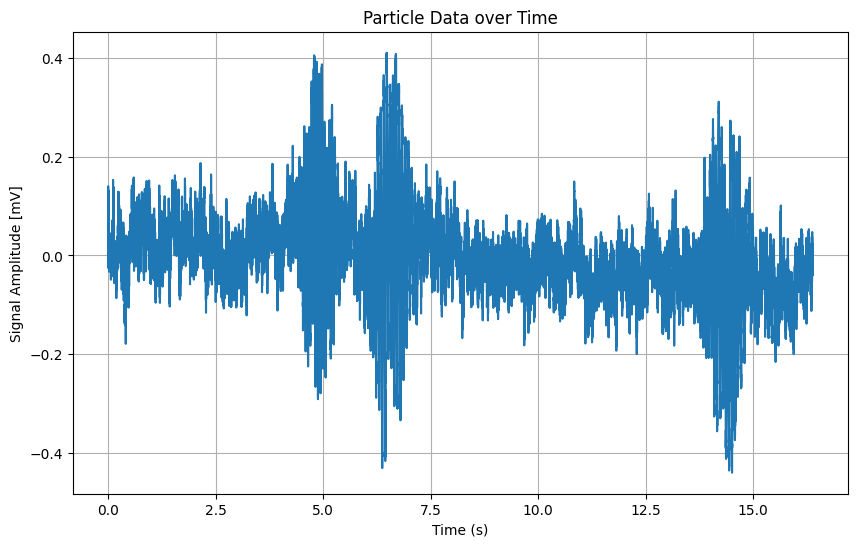

In [9]:
# Plot the RAW particle data
plt.figure(figsize=(10, 6))
plt.plot(time_axis, particle_data)
plt.title('Particle Data over Time')
plt.xlabel('Time (s)')
plt.ylabel('Signal Amplitude [mV]')
plt.grid(True)
plt.show()

In [18]:
def plot_spectrogram_with_bokeh(file, adq_freq, time_captured_ms, particle_params):
    # Load particle data from the file
    data_Y = np.load(file)
    data_Y = pd.Series(data_Y)

    # Calculate time axis
    data_X_max = time_captured_ms * 1000 / adq_freq
    data_X = np.linspace(0, data_X_max, time_captured_ms)

    # Remove DC offset
    data_Y_NoOffset = data_Y - data_Y.mean()

    # Apply bandpass filter to the signal
    y_Filtrada = butter_bandpass_filter(data_Y_NoOffset, 7000, 100000, 4, adq_freq)

    # Perform FFT
    ampFFT1, freqfft1, _ = FFT_calc(y_Filtrada, adq_freq)

    # Apply Gaussian smoothing and find peaks
    std_dev = 20
    cut_index = int(len(ampFFT1) / 10)
    new_FFT = ampFFT1[0:cut_index]
    filtered_fft = gaussian_filter1d(new_FFT, sigma=std_dev)

    # Find peaks in the FFT
    mean_amplitude = max(filtered_fft) / 2
    peaks, properties = find_peaks(filtered_fft, height=mean_amplitude)
    peak_amplitudes = properties["peak_heights"]

    # Sort peaks by amplitude and apply a minimum distance criterion
    sorted_indices = np.argsort(peak_amplitudes)[::-1]
    sorted_peaks = peaks[sorted_indices]
    min_distance = 12000
    valid_peaks = []

    # Ensure valid peaks are spaced by at least 12 kHz
    for peak in sorted_peaks:
        if all(abs(freqfft1[peak] - freqfft1[vp]) >= min_distance for vp in valid_peaks):
            valid_peaks.append(peak)

    # Spectrogram centered around the valid peaks (assuming find_spectogram is defined)
    t, f_new, Sxx_new = find_spectogram(y_Filtrada, adq_freq, ampFFT1, freqfft1, particle_params)

    # Calculate the general mean for plotting
    general_mean = np.mean(Sxx_new, axis=0)

    # Adjust time axis for the spectrogram plot
    t = np.linspace(0, max(data_X), len(general_mean))

    # Setup Bokeh plot for the spectrogram
    spectrogram_fig = figure(title="Spectrogram", x_axis_label="Time (s)", y_axis_label="Frequency (Hz)",
                             plot_width=800, plot_height=400)

    # Setup the color mapper based on the Viridis palette
    color_mapper = LinearColorMapper(palette=Viridis256, low=np.min(Sxx_new), high=np.max(Sxx_new))

    # Plot the spectrogram image
    spectrogram_fig.image(image=[Sxx_new], x=0, y=0, dw=t[-1], dh=f_new[-1], color_mapper=color_mapper)

    # Show the Bokeh plot
    show(spectrogram_fig)


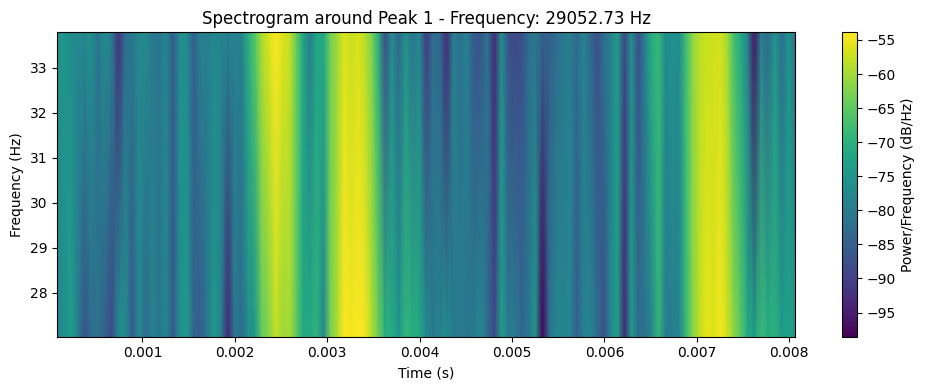

In [19]:
plot_spectrograms_for_peaks(Sample_to_plot, Adq_Freq, Time_Captured_ms, Particle_Params)